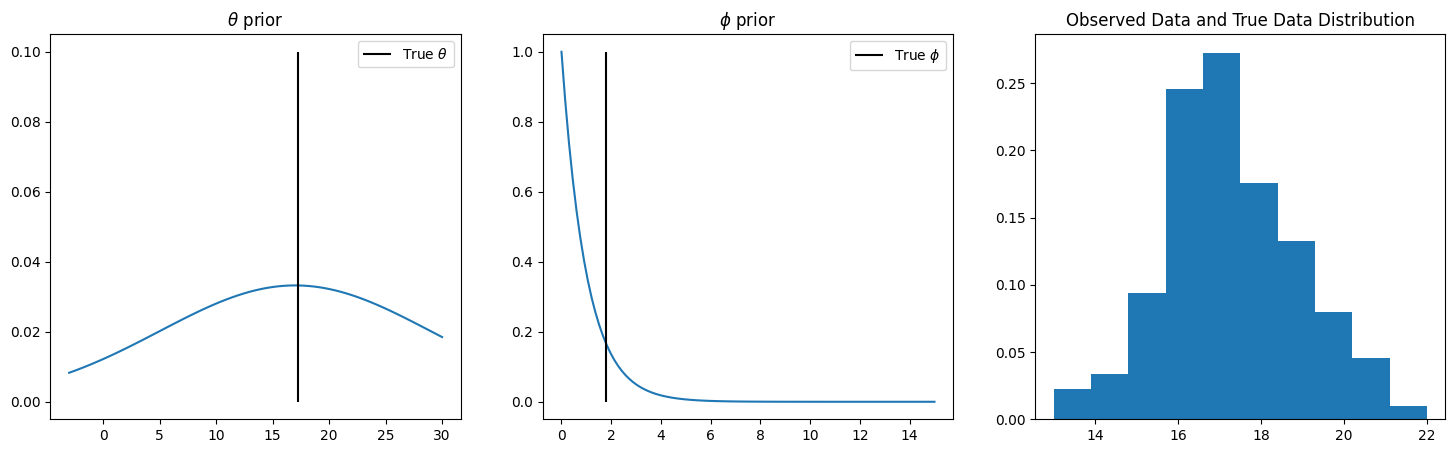

In [57]:
import numpy as np; from scipy import stats; import matplotlib.pyplot as plt; import pandas as pd; import pymc as pm; import arviz as az
#import the data
data = pd.read_csv('Cricket_chirps.csv')
#choose the column that justifies normal-gamma specification
chirps = data["Chirps per second"]

normal_gamma_toy_model = pm.Model()
theta_0,tau = 17,12; alpha,beta = 1,1
theta_prior = stats.norm(loc=theta_0, scale=tau)
phi_prior = stats.gamma(a=alpha, scale=1/beta)
theta_true = np.mean(chirps)
phi_true = np.std(chirps)


Rplus = np.linspace(0,15,100); Rpm = np.linspace(-3,30,100)
fig,ax = plt.subplots(1,3,figsize=(18,5)); ax[0].plot(Rpm, theta_prior.pdf(Rpm)); ax[0].set_title('$\\theta$ prior'); ax[0].vlines(theta_true,0,.1,'k',label='True $\\theta$'); ax[0].legend(); ax[1].plot(Rplus, phi_prior.pdf(Rplus)); ax[1].vlines(phi_true,0,1,'k',label='True $\\phi$'); ax[1].legend(); ax[1].set_title('$\\phi$ prior'); ax[2].hist(x, density=True); ax[2].set_title('Observed Data and True Data Distribution');
#we see the data is normally distributed

HMC Split-Rhats {'theta': 1.001, 'phi': 1.0} | MH Split-Rhats {'theta': 1.0012, 'phi': 1.0009}


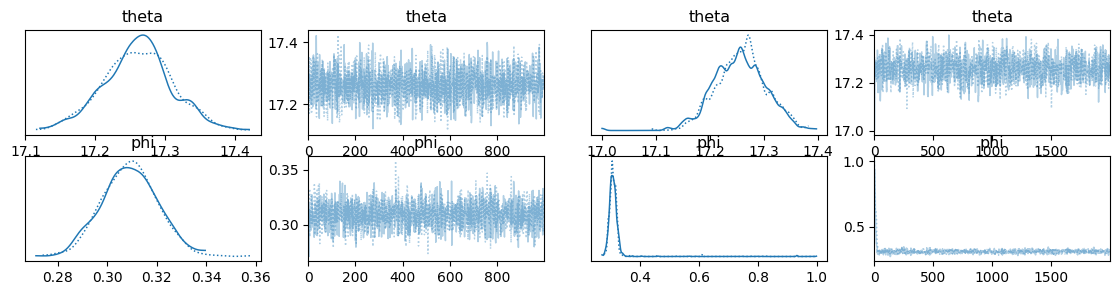

In [64]:
normal_gamma_toy_model = pm.Model()
with normal_gamma_toy_model:
    theta = pm.Normal("theta", mu=17, sigma=12)
    phi = pm.Gamma("phi", alpha=1, beta=1)
    x_obs = pm.Normal("likelihood", mu=theta, sigma=1/phi**0.5, observed=chirps)
    idata_HMC = pm.sample()

with normal_gamma_toy_model:
    MH = pm.Metropolis([theta, phi], S=np.array([0.1]), tune=False, tune_interval=0)
    idata_MH = pm.sample(step=MH)

import matplotlib.pyplot as plt; fig,ax = plt.subplots(2,4, figsize=(14,3))
az.plot_trace(idata_HMC, axes=ax[:2,:2]); az.plot_trace(idata_MH, axes=ax[:2,2:])
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC).items()}, end=' | '); print('MH Split-Rhats',{k: np.round(v.values,4) for k,v in az.rhat(idata_MH).items()})
#we see that the data seem to be converging fine for both HMC and MH.

Autocorrelation for HMC (MCMC) chain 0.032730521667416655
Autocorrelation for MH (MCMC) chain 0.9782073249256688


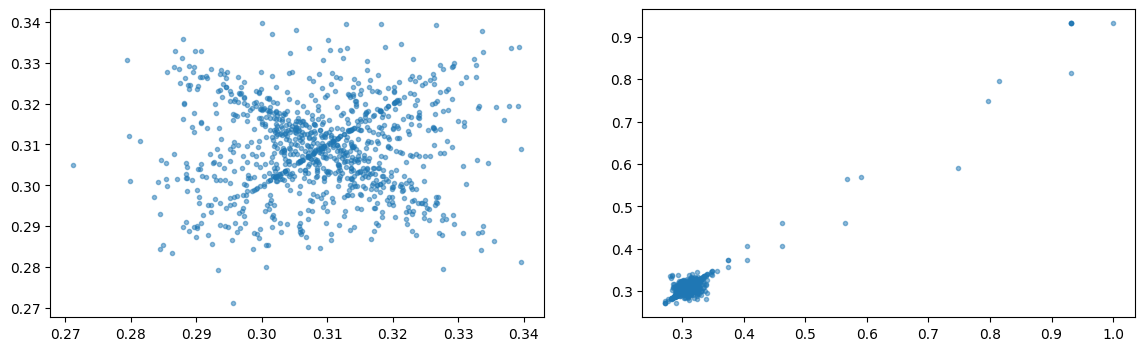

In [78]:
fig,ax = plt.subplots(1,2, figsize=(14,4))
max_mcmc_samples = 1000
mcmc_chain = idata_HMC.posterior["phi"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values; mcmc_chain_one_step_ahead = idata_HMC.posterior["phi"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values; ax[0].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5)
print("Autocorrelation for HMC (MCMC) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])
mcmc_chain = idata_MH.posterior["phi"].sel(chain=0, draw=slice(0, max_mcmc_samples-2)).values; mcmc_chain_one_step_ahead = idata_MH.posterior["phi"].sel(chain=0, draw=slice(1, max_mcmc_samples-1)).values; ax[1].plot(mcmc_chain, mcmc_chain_one_step_ahead, '.', alpha=0.5);
print("Autocorrelation for MH (MCMC) chain", np.corrcoef(mcmc_chain,mcmc_chain_one_step_ahead)[0,1])
# The autocoreelation for HMC is low but really high for MH, which is not a good sign


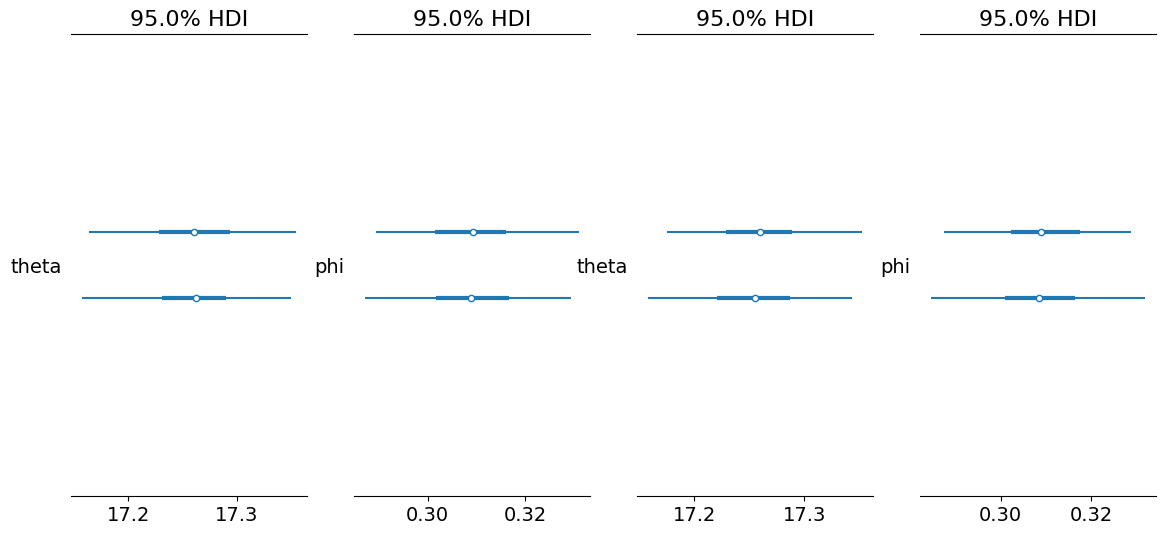

In [85]:
import arviz as az; import matplotlib.pyplot as plt; fig,ax = plt.subplots(1,4, figsize=(14,6))
az.plot_forest(idata_HMC, var_names=["theta"], combined=False, hdi_prob=0.95, ax=ax[0]);
az.plot_forest(idata_HMC, var_names=["phi"], combined=False, hdi_prob=0.95, ax=ax[1]);
az.plot_forest(idata_MH, var_names=["theta"], combined=False, hdi_prob=0.95, ax=ax[2]);
az.plot_forest(idata_MH, var_names=["phi"], combined=False, hdi_prob=0.95, ax=ax[3]);
#the credible intervals of HMC is reliable as it converges with a low autocorrelation. But the MH, the correlation is too high even if it converged.

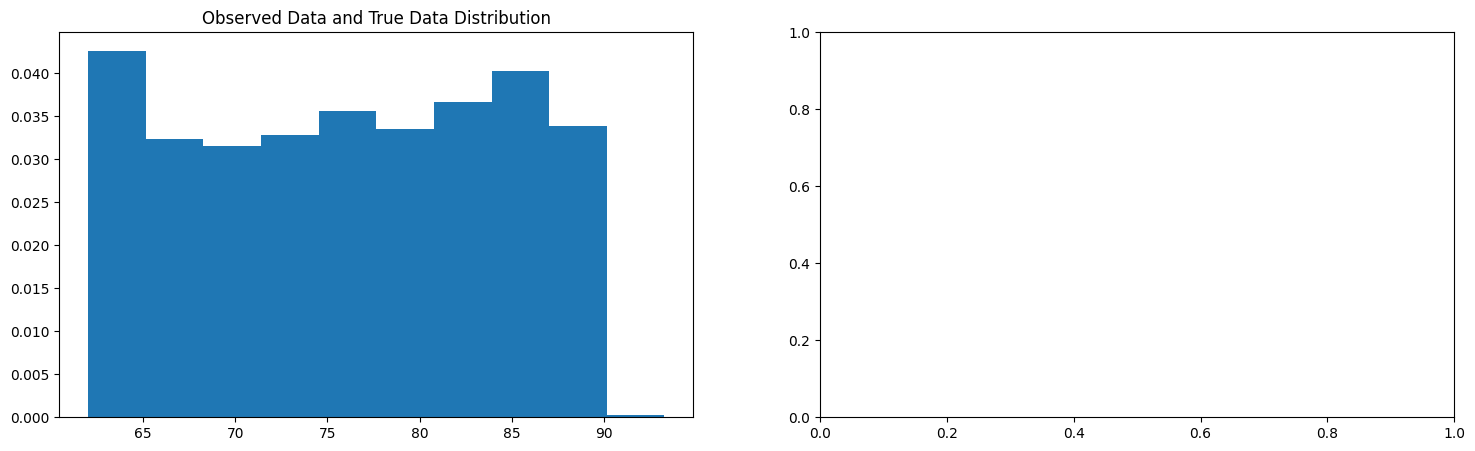

In [104]:
#choose the column that doesn't justify normal-gamma specification
temp = data["Temperature"]

normal_gamma_toy_model = pm.Model()
upperb,lowerb = 63,93.3;
theta_prior = stats.uniform(loc=upperb, scale=lowerb)


Rplus = np.linspace(0,15,100); Rpm = np.linspace(-3,30,100)
fig,ax = plt.subplots(1,2,figsize=(18,5)); ax[0].hist(temp, density=True); ax[0].set_title('Observed Data and True Data Distribution');

HMC Split-Rhats {'lower': 1.0049, 'upper': 1.002} | MH Split-Rhats {'lower': 1.002, 'upper': 1.0074}


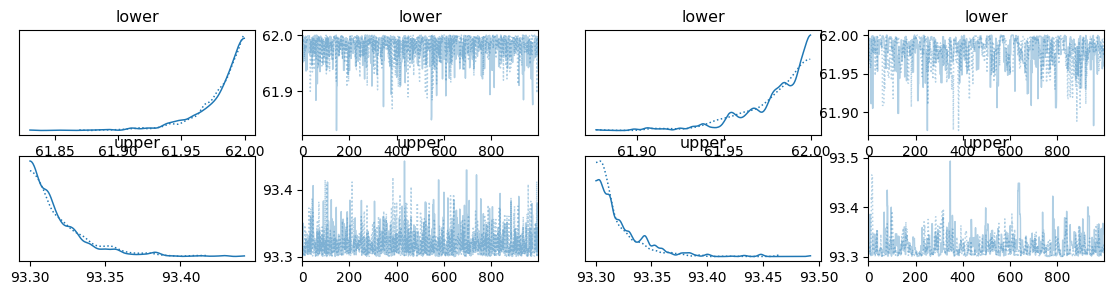

In [109]:

uniform_model = pm.Model()
with uniform_model:
    lower = pm.Uniform('lower', lower=np.min(temp) - 1, upper=np.min(temp))

    upper = pm.Uniform('upper', lower=np.max(temp), upper=np.max(temp) + 1)

    observed_data = pm.Uniform('observed_data', lower=lower, upper=upper, observed=temp)

    uni_HMC = pm.sample()

with uniform_model:
    MH = pm.Metropolis()
    uni_MH = pm.sample(step=MH)

fig,ax = plt.subplots(2,4, figsize=(14,3))
az.plot_trace(uni_HMC, axes=ax[:2,:2]); az.plot_trace(uni_MH, axes=ax[:2,2:])
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(uni_HMC).items()}, end=' | '); print('MH Split-Rhats',{k: np.round(v.values,4) for k,v in az.rhat(uni_MH).items()})
#The data convergence for both HMC and MH


Autocorrelation for 'lower' (MH MCMC) chain: 0.2556960016543756
Autocorrelation for 'upper' (MH MCMC) chain: 0.17249825854835654


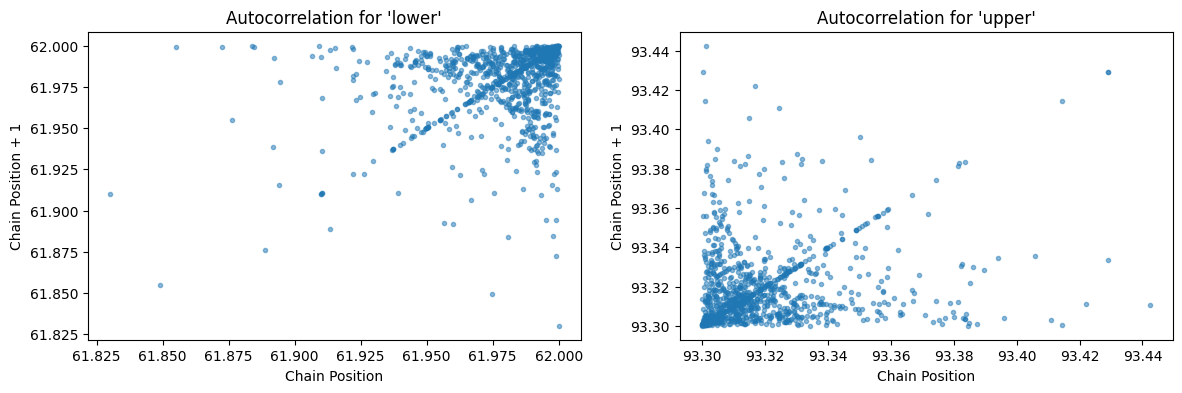

In [111]:
max_mcmc_samples = 1000

max_mcmc_samples = len(uni_HMC.posterior['lower'].values[0])  # Assuming one chain for simplicity


mhmc_chain_lower = uni_HMC.posterior['lower'].values[0, :max_mcmc_samples-1]
mhmc_chain_lower_one_step_ahead = uni_HMC.posterior['lower'].values[0, 1:max_mcmc_samples]

# Plotting for lower
fig,ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].plot(mhmc_chain_lower, mhmc_chain_lower_one_step_ahead, '.', alpha=0.5); ax[0].set_title("Autocorrelation for 'lower'"); ax[0].set_xlabel('Chain Position'); ax[0].set_ylabel('Chain Position + 1')

autocorr_lower = np.corrcoef(mhmc_chain_lower, mhmc_chain_lower_one_step_ahead)[0, 1]
print("Autocorrelation for 'lower' (HMC MCMC) chain:", autocorr_lower)


mhmc_chain_upper = uni_HMC.posterior['upper'].values[0, :max_mcmc_samples-1]
mhmc_chain_upper_one_step_ahead = uni_HMC.posterior['upper'].values[0, 1:max_mcmc_samples]

ax[1].plot(mhmc_chain_upper, mhmc_chain_upper_one_step_ahead, '.', alpha=0.5);ax[1].set_title("Autocorrelation for 'upper'");ax[1].set_xlabel('Chain Position');ax[1].set_ylabel('Chain Position + 1');

autocorr_upper = np.corrcoef(mhmc_chain_upper, mhmc_chain_upper_one_step_ahead)[0, 1]
print("Autocorrelation for 'upper' (HMC MCMC) chain:", autocorr_upper)
#the autocorrelation is not that high for both HMC and MH

Autocorrelation for 'lower' (MH MCMC) chain: 0.5907824775086804
Autocorrelation for 'upper' (MH MCMC) chain: 0.6047625617511093


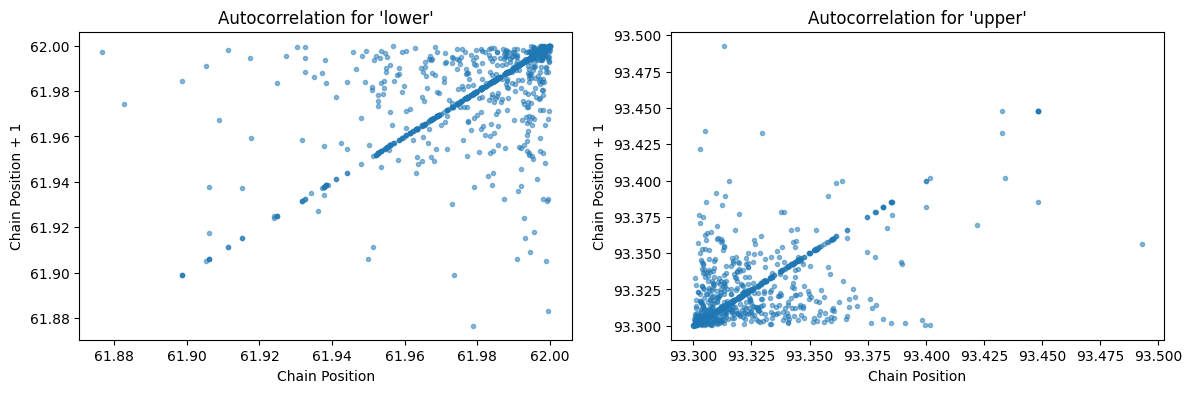

In [112]:


max_mcmc_samples = len(uni_MH.posterior['lower'].values[0])  # Assuming one chain for simplicity


mhmc_chain_lower = uni_MH.posterior['lower'].values[0, :max_mcmc_samples-1]
mhmc_chain_lower_one_step_ahead = uni_MH.posterior['lower'].values[0, 1:max_mcmc_samples]

# Plotting for lower
fig,ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].plot(mhmc_chain_lower, mhmc_chain_lower_one_step_ahead, '.', alpha=0.5); ax[0].set_title("Autocorrelation for 'lower'"); ax[0].set_xlabel('Chain Position'); ax[0].set_ylabel('Chain Position + 1')

autocorr_lower = np.corrcoef(mhmc_chain_lower, mhmc_chain_lower_one_step_ahead)[0, 1]
print("Autocorrelation for 'lower' (MH MCMC) chain:", autocorr_lower)


mhmc_chain_upper = uni_MH.posterior['upper'].values[0, :max_mcmc_samples-1]
mhmc_chain_upper_one_step_ahead = uni_MH.posterior['upper'].values[0, 1:max_mcmc_samples]

ax[1].plot(mhmc_chain_upper, mhmc_chain_upper_one_step_ahead, '.', alpha=0.5);ax[1].set_title("Autocorrelation for 'upper'");ax[1].set_xlabel('Chain Position');ax[1].set_ylabel('Chain Position + 1');

autocorr_upper = np.corrcoef(mhmc_chain_upper, mhmc_chain_upper_one_step_ahead)[0, 1]
print("Autocorrelation for 'upper' (MH MCMC) chain:", autocorr_upper)
#the autocorrelation is a bit high, thus the credible interval might not be produced reliably

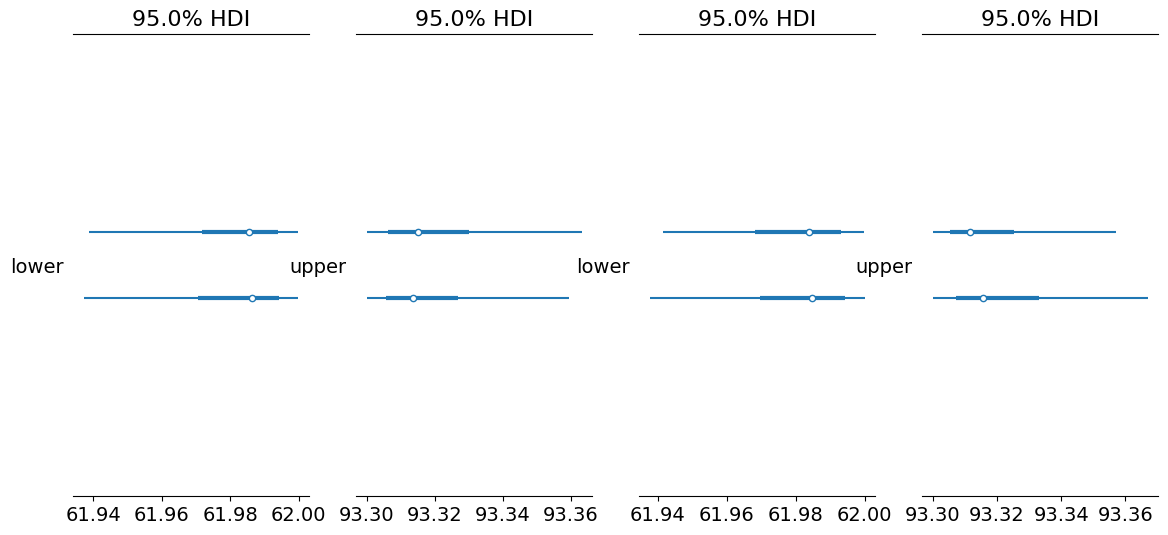

In [115]:
import arviz as az; import matplotlib.pyplot as plt; fig,ax = plt.subplots(1,4, figsize=(14,6))
az.plot_forest(uni_HMC, var_names=["lower"], combined=False, hdi_prob=0.95, ax=ax[0]);
az.plot_forest(uni_HMC, var_names=["upper"], combined=False, hdi_prob=0.95, ax=ax[1]);
az.plot_forest(uni_MH, var_names=["lower"], combined=False, hdi_prob=0.95, ax=ax[2]);
az.plot_forest(uni_MH, var_names=["upper"], combined=False, hdi_prob=0.95, ax=ax[3]);
#It is worth noticing that the credible interval from MH might not be reliable as it has a bit high autocorrelation